## 解压

In [1]:
import zipfile
from os.path import isfile, isdir

def unzip_file(f_path):
    fzip = zipfile.ZipFile(f_path)
    fzip.extractall()

train = './train.zip'
train_folder = './train'
test = './test.zip'
test_folder = './test'

if not isdir(train_folder):
    unzip_file(train)
if not isdir(test_folder):
    unzip_file(test)

## 探索数据集

In [2]:
from tqdm import tqdm
import os
import cv2

train_info = []
for img in tqdm(os.listdir(train_folder)):
    info = cv2.imread(os.path.join(train_folder, img))
    train_info.append((info.shape, img))
    #train_info.append((os.path.getsize(os.path.join(train_folder, img)), img))

100%|██████████| 25000/25000 [01:08<00:00, 364.99it/s]


In [3]:
len(train_info)
train_info[0]

((500, 380, 3), 'dog.8011.jpg')

### 图片大小分布情况

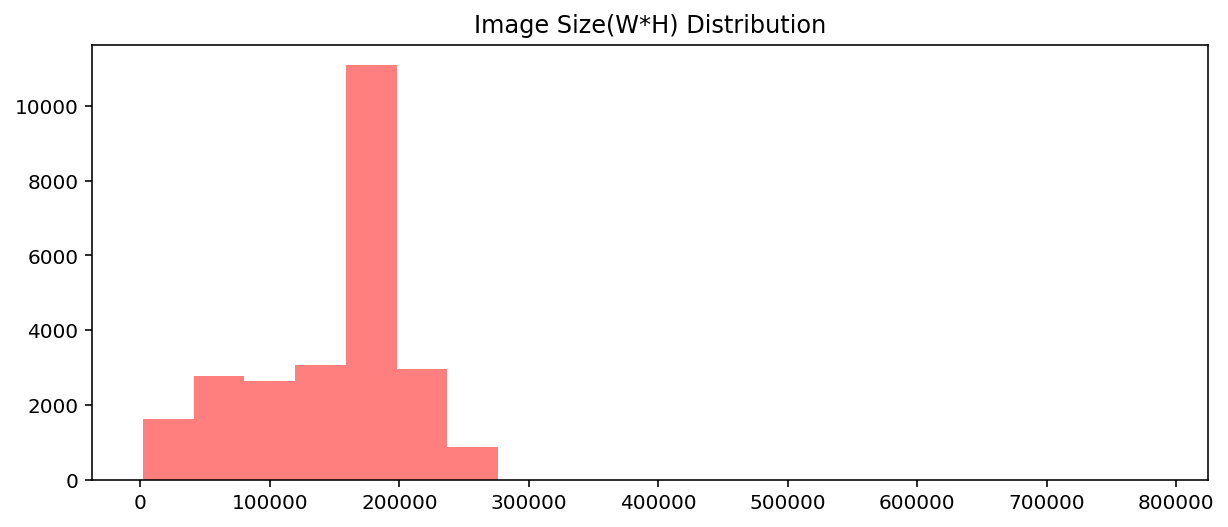

In [32]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
img_size = [info[0][0]*info[0][1] for info in train_info]
plt.title("Image Size(W*H) Distribution")
plt.hist(img_size, bins = 20, alpha = 0.5, color = 'red', label = 'image_size')
plt.show()

In [5]:
len(img_size)
img_size[0]

570000

### 显示图片

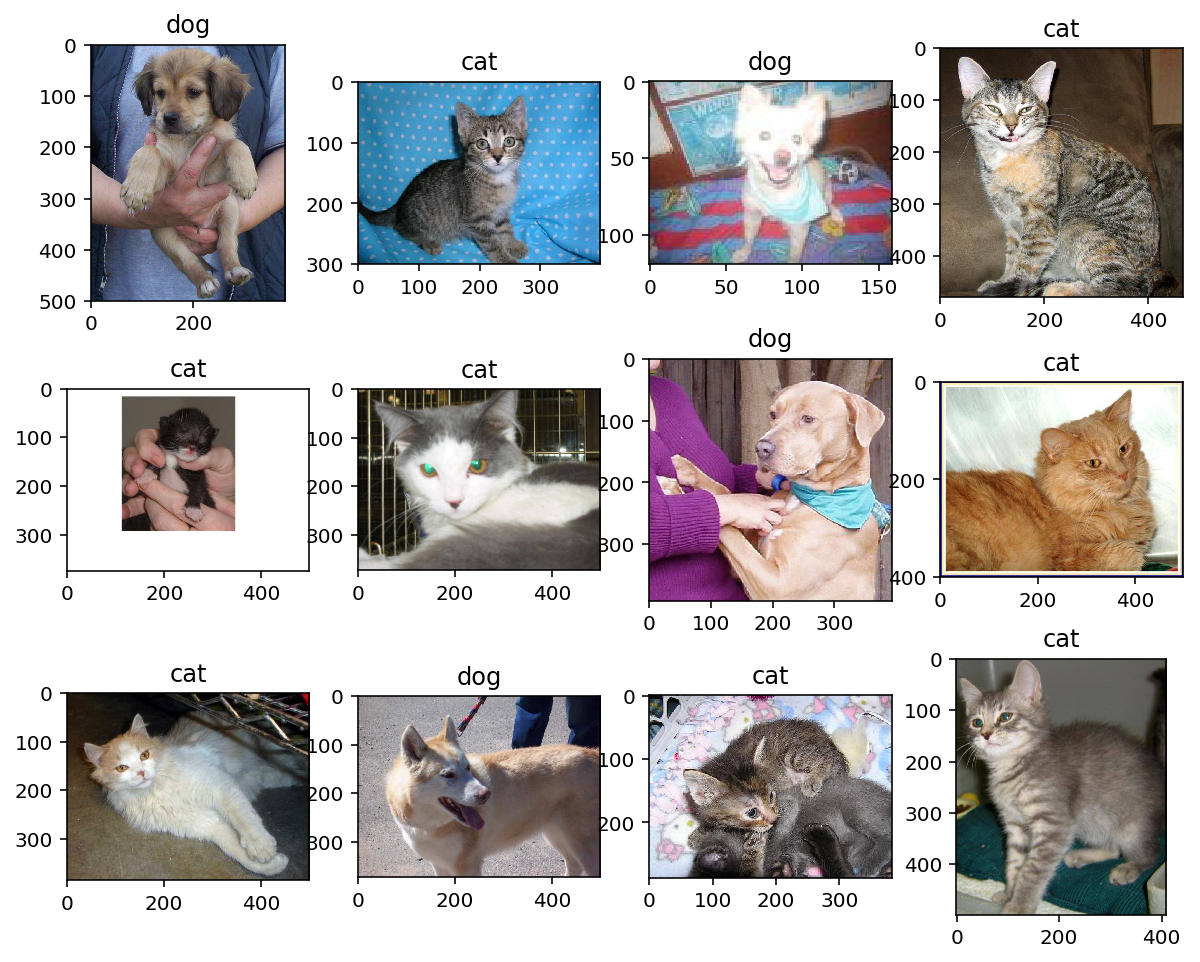

In [30]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir(train_folder)[:12]):
    img = plt.imread(os.path.join(train_folder, file))
    plt.subplot(3, 4, i+1)
    plt.title(file.split('.')[0])
    plt.axis('on')
    plt.imshow(img)

plt.show()

In [29]:
img = cv2.imread(os.path.join(train_folder, os.listdir(train_folder)[4]))
img.shape

(375, 499, 3)

In [22]:
os.listdir(train_folder)[4]

'cat.10151.jpg'

## 加载数据集

打label，狗对应1，猫对应0

In [58]:
import cv2
from tqdm import tqdm
import os

IMG_SIZE = 224

Train_X = np.zeros((25000, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
Train_Y = np.zeros((25000, 1), dtype=np.uint8)
for i, img_file in enumerate(tqdm(os.listdir(train_folder))):
    Train_X[i] = cv2.resize(cv2.imread(os.path.join(train_folder, img_file)), (IMG_SIZE, IMG_SIZE))
    Train_Y[i] = 1 if 'dog' in img_file else 0

100%|██████████| 25000/25000 [01:30<00:00, 275.53it/s]


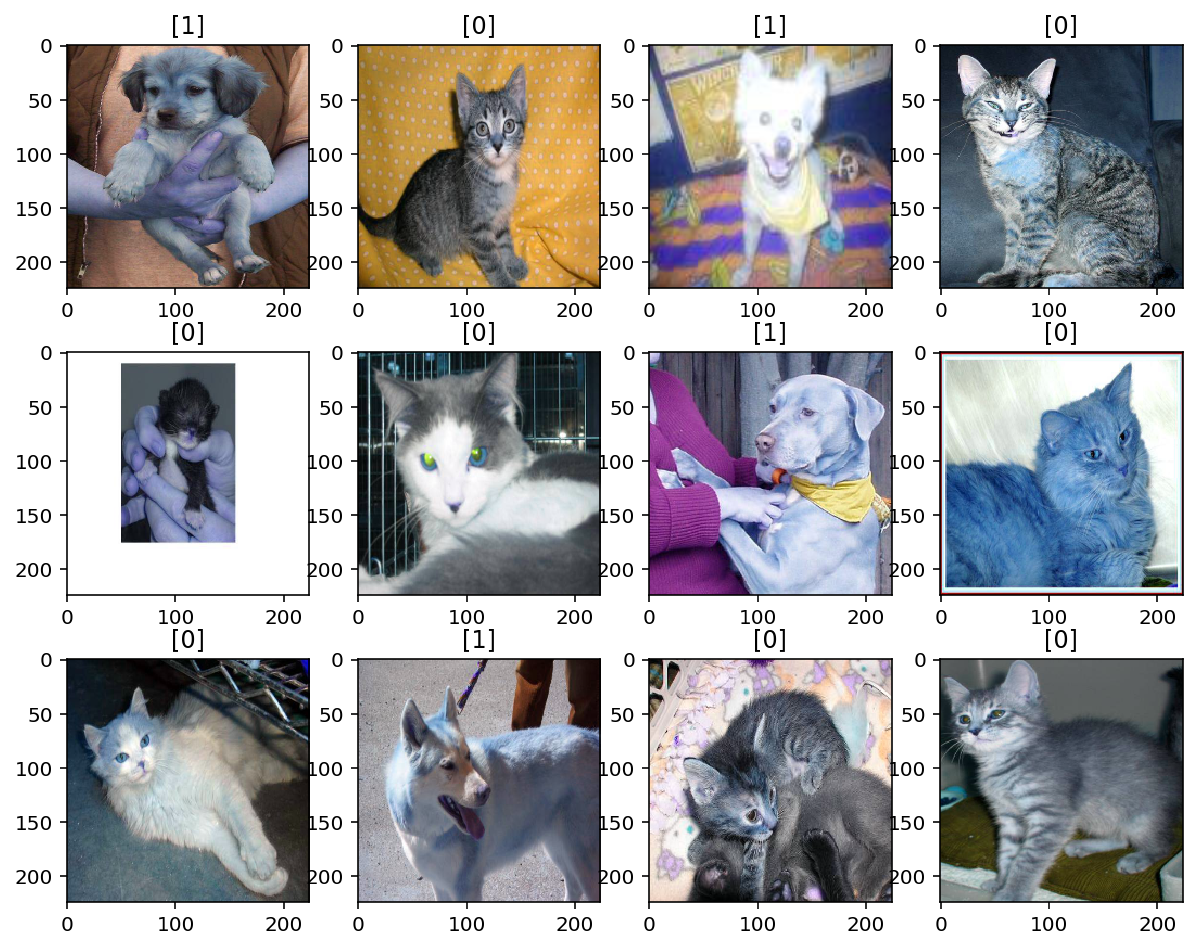

In [43]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 8))
for i, (img, label) in enumerate(zip(Train_X[:12], Train_Y[:12])):
    plt.subplot(3, 4, i+1)
    plt.title(str(label))
    plt.axis('on')
    plt.imshow(img)

plt.show()

### 数据预处理

In [71]:
def normalize(x):
    x = np.array(x, dtype=np.float)
    x = (x - 128) / 128
    return x

In [75]:
batch = 5000
X = np.zeros((25000, IMG_SIZE, IMG_SIZE, 3), dtype=np.float)
for i in range(0, len(Train_X), batch):
    X[i:(i+batch)] = normalize(Train_X[i:(i+batch)])

In [8]:
X.shape

NameError: name 'X' is not defined

### 保存训练数据

(375, 499, 3)

## 另一种数据预处理方法（使用Keras ImageDataGenerator）

### 建立分类目录

In [2]:
import os, shutil
from os.path import isfile, isdir

TRAIN_GEN = './train_gen'
TRAIN_GEN_DOG = './train_gen/dog'
TRAIN_GEN_CAT = './train_gen/cat'
VAL_GEN = './val_gen'
VAL_GEN_DOG = './val_gen/dog'
VAL_GEN_CAT = './val_gen/cat'

TEST_GEN = './test_gen'
TEST_GEN_MIXED = './test_gen/mixed'

train_cat = [file for file in os.listdir(train_folder) if 'cat' in file]
train_dog = [file for file in os.listdir(train_folder) if 'dog' in file]

val_num = int(len(train_dog) * .2)
val_dog = train_dog[-val_num:]
train_dog = train_dog[:-val_num]

val_cat = train_cat[-val_num:]
train_cat = train_cat[:-val_num]

len(train_dog)
len(val_dog)

2500

In [3]:
if not isdir(TRAIN_GEN):
    os.mkdir(TRAIN_GEN)
    os.mkdir(TRAIN_GEN_DOG)
    os.mkdir(TRAIN_GEN_CAT)
    for file in train_dog:
        os.symlink('../../train/'+file, TRAIN_GEN_DOG+r'/'+file)
    for file in train_cat:
        os.symlink('../../train/'+file, TRAIN_GEN_CAT+r'/'+file)

if not isdir(VAL_GEN):
    os.mkdir(VAL_GEN)
    os.mkdir(VAL_GEN_DOG)
    os.mkdir(VAL_GEN_CAT)
    for file in val_dog:
        os.symlink('../../train/'+file, VAL_GEN_DOG+r'/'+file)
    for file in val_cat:
        os.symlink('../../train/'+file, VAL_GEN_CAT+r'/'+file)

if not isdir(TEST_GEN):
    os.mkdir(TEST_GEN)
    os.mkdir(TEST_GEN_MIXED)
    for file in os.listdir(test_folder)[:]:
        os.symlink('../../test/'+file, TEST_GEN_MIXED+r'/'+file)

### 创建 ImageDataGenerator

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=None,
    rescale=None,
    )

Using TensorFlow backend.


### 使用 .flow 方法

(1, 396, 312, 3)


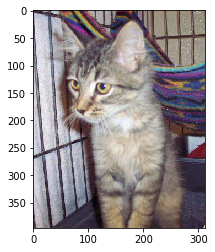

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

img = plt.imread(os.path.join(train_folder, 'cat.2.jpg'))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print(img.shape)
#print(img)

(1, 396, 312, 3)
[[[-1.30499947 -1.25105119 -1.41578472]
  [-1.268924   -1.21729469 -1.37950563]
  [-1.61164081 -1.55486    -1.70601785]
  ..., 
  [ 0.17409424  0.23423615 -0.12787543]
  [-0.09647168 -0.01893783 -0.39996895]
  [-0.49330169 -0.42401621 -0.81717902]]

 [[-1.44930124 -1.43671215 -1.57904088]
  [-1.34107494 -1.35232079 -1.43392432]
  [-1.46733904 -1.47046864 -1.56090128]
  ..., 
  [ 0.69718838  0.68994933  0.38003248]
  [ 0.10194333  0.13296656 -0.21857327]
  [-0.69171673 -0.60967714 -1.01671422]]

 [[-0.87209398 -0.94724244 -0.94415599]
  [-1.07050896 -1.13290334 -1.1074121 ]
  [-1.50341451 -1.53798175 -1.54276168]
  ..., 
  [ 0.53484881  0.53804493  0.21677636]
  [ 0.19213197  0.18360135 -0.14601499]
  [-0.49330169 -0.45777273 -0.83531857]]

 ..., 
 [[ 0.2101697   0.23423615  0.36189291]
  [-0.4211508  -0.35650313 -0.27299196]
  [-1.25088632 -1.18353808 -1.16183078]
  ..., 
  [-1.1606977  -1.13290334 -1.17997038]
  [ 0.57092428  0.48741013  0.48886988]
  [ 1.34654653  1.

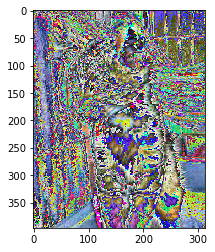

In [14]:
img_generator.fit(img)
gen = img_generator.flow(img, batch_size=1)

plt.figure()
for i in range(0, 1):
    plt.subplot(1, 1, i+1)
    batch = gen.next()
    print(batch.shape)
    #print(batch[0])
    plt.imshow(batch[0])
    

----
# ResNet50

## 创建 ImageDataGenerator

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=preprocess_input,
    rescale=None,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    channel_shift_range=10,
    horizontal_flip=True,
    )

Using TensorFlow backend.


In [6]:
IMG_SIZE = 224
batch_size = 128

train_gen = img_generator.flow_from_directory(
    TRAIN_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_gen = img_generator.flow_from_directory(
    VAL_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [11]:
train_gen.class_indices

{'cat': 0, 'dog': 1}

In [76]:
print(len(train_gen.filenames))
train_gen.filenames[:20]

20000


['cat/cat.0.jpg',
 'cat/cat.1.jpg',
 'cat/cat.10.jpg',
 'cat/cat.100.jpg',
 'cat/cat.1000.jpg',
 'cat/cat.10004.jpg',
 'cat/cat.10005.jpg',
 'cat/cat.10008.jpg',
 'cat/cat.10009.jpg',
 'cat/cat.1001.jpg',
 'cat/cat.10010.jpg',
 'cat/cat.10011.jpg',
 'cat/cat.10018.jpg',
 'cat/cat.10019.jpg',
 'cat/cat.1002.jpg',
 'cat/cat.10020.jpg',
 'cat/cat.10021.jpg',
 'cat/cat.10022.jpg',
 'cat/cat.10023.jpg',
 'cat/cat.10024.jpg']

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


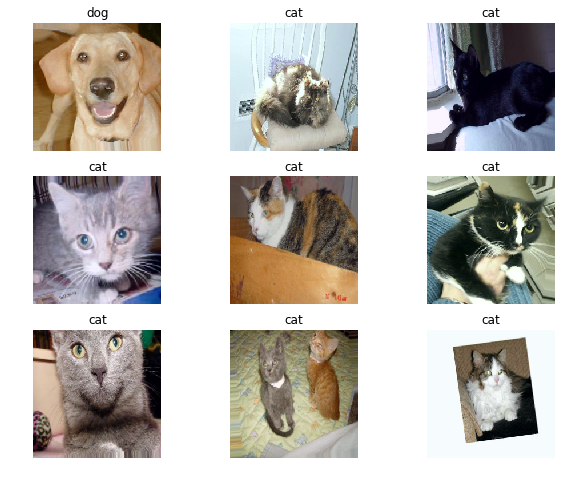

In [73]:
plt.figure(figsize=(10, 8))

batch, label = train_gen.next()
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    print(batch[i].shape)
    plt.title('dog' if label[i] else 'cat')
    #print(batch[i])
    plt.axis('off')
    plt.imshow(batch[i].astype(np.uint8))
plt.show()

In [7]:
from keras.applications.imagenet_utils import preprocess_input

test_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=preprocess_input,
    rescale=None,
    )

test_gen = test_generator.flow_from_directory(
    TEST_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

Found 12500 images belonging to 1 classes.


## 构建模型

In [45]:
from keras.applications import resnet50, imagenet_utils
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Lambda

# preprocess_input
input_tensor=Input((IMG_SIZE, IMG_SIZE, 3))
x = input_tensor
#x = Lambda(imagenet_utils.preprocess_input)(x)

# base model from ResNet50
base_model = resnet50.ResNet50(input_tensor=x, weights='imagenet', include_top=False)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# add a fully-connected layer
#x = Dense(1024, activation='relu')(x)

# and a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=input_tensor, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Fine Tune

In [49]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

# this is the model we will train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 训练模型

In [47]:
epochs = 10
patience = 5

In [52]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

check_pt = ModelCheckpoint(
    'resnet50_{epoch:02d}_{val_loss:.4f}.hdf5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    period=1
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.002,
    patience=patience, 
    verbose=1, 
    mode='auto'
)

In [53]:
result = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=[check_pt, early_stop],
    )

Epoch 1/10
157/157 [==============================] - 350s 2s/step - loss: 0.0719 - acc: 0.9725 - val_loss: 0.0384 - val_acc: 0.9866

Epoch 00001: saving model to resnet50_01_0.0384.hdf5
Epoch 2/10
157/157 [==============================] - 333s 2s/step - loss: 0.0410 - acc: 0.9840 - val_loss: 0.0747 - val_acc: 0.9764

Epoch 00002: saving model to resnet50_02_0.0747.hdf5
Epoch 3/10
157/157 [==============================] - 336s 2s/step - loss: 0.0314 - acc: 0.9884 - val_loss: 0.0592 - val_acc: 0.9810

Epoch 00003: saving model to resnet50_03_0.0592.hdf5
Epoch 4/10
157/157 [==============================] - 332s 2s/step - loss: 0.0224 - acc: 0.9919 - val_loss: 0.0539 - val_acc: 0.9844

Epoch 00004: saving model to resnet50_04_0.0539.hdf5
Epoch 00004: early stopping


## 可视化训练结果

In [34]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def visualize_training(epoch, history):
    plt.figure(figsize=(8, 4))
    plt.plot(epoch, history['acc'], label="acc")
    plt.plot(epoch, history['val_acc'], label="val_acc")
    plt.scatter(epoch, history['acc'], marker='*')
    plt.scatter(epoch, history['val_acc'], marker='*')
    plt.legend(loc='center right')

    plt.plot(epoch, history['loss'], label="loss")
    plt.plot(epoch, history['val_loss'], label="val_loss")
    plt.scatter(epoch, history['loss'], marker='*')
    plt.scatter(epoch, history['val_loss'], marker='*')
    plt.legend(loc='center right')
    plt.show()

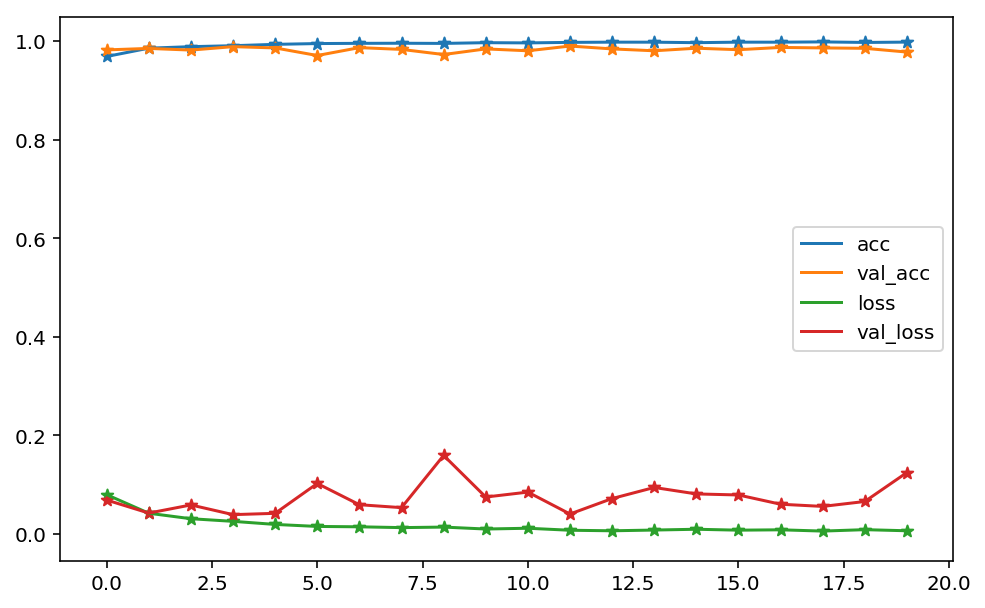

In [24]:
visualize_training(result.epoch, result.history)

In [26]:
import numpy as np

def save_training_log(history, file):
    train_acc = history['acc']
    train_loss = history['loss']

    val_acc = history['val_acc']
    val_loss = history['val_loss']

    np.savez(file, acc=train_acc, loss=train_loss, val_acc=val_acc, val_loss=val_loss)

def load_training_log(file):
    history = {}
    r = np.load(file)
    history['acc'] = r['acc']
    history['loss'] = r['loss']
    history['val_acc'] = r['val_acc']
    history['val_loss'] = r['val_loss']
    epoch = list(range(0, len(r['acc'])))
    
    return (epoch, history)

In [26]:
save_training_log(result.history, 'log_resnet50.npz')

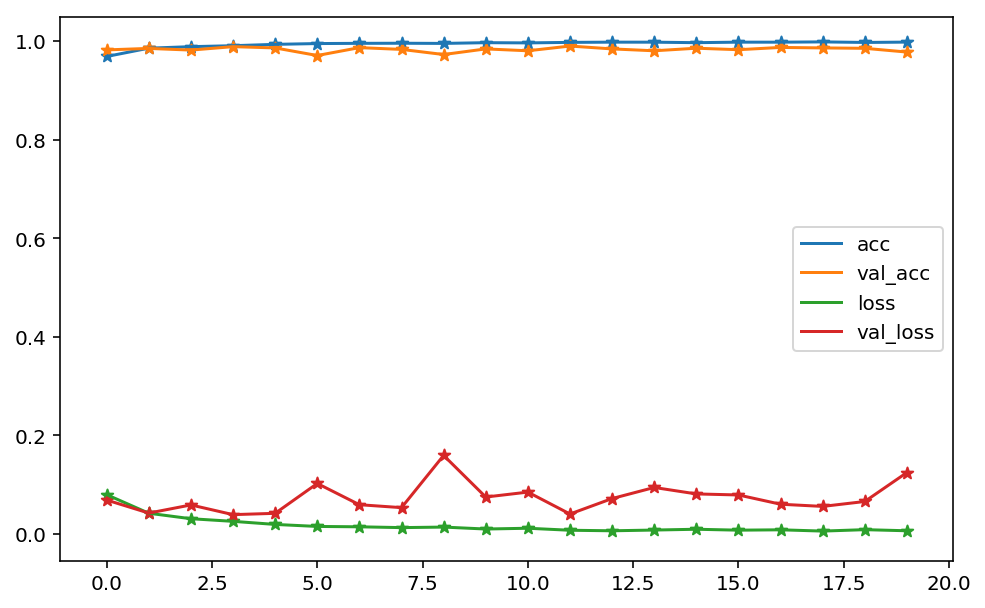

In [27]:
epoch, log = load_training_log('log_resnet50.npz')
visualize_training(epoch, log)

## 保存模型

In [28]:
WEIGHT = 'weight_resnet50'
MODEL_ = 'model_resnet50'

# save model
with open(MODEL_+'.json', 'w') as f:
    f.write(model.to_json())

# save weights
if not os.path.isfile(WEIGHT+'.h5'):
    model.save_weights(WEIGHT+'.h5', overwrite=True)

## 恢复模型

In [29]:
from keras.models import Model, model_from_json

# restore model
json_file = open(MODEL_+'.json', 'r')  
loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# restore weights
loaded_model.load_weights(WEIGHT+'.h5')

In [54]:
from keras.models import load_model

best_model = 'resnet50_01_0.0384.hdf5'

# restore both weights and model arch.
loaded_model = load_model(best_model)

## 预测

In [56]:
model = loaded_model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [57]:
import pandas as pd

y_pred = model.predict_generator(test_gen, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_resnet50.csv', index=None)
df.head(20)

98/98 [==============================] - 125s 1s/step


id     label
0    1  0.995000
1    2  0.995000
2    3  0.995000
3    4  0.995000
4    5  0.005000
5    6  0.005000
6    7  0.005000
7    8  0.005000
8    9  0.005000
9   10  0.005000
10  11  0.005000
11  12  0.995000
12  13  0.005000
13  14  0.014636
14  15  0.005000
15  16  0.005000
16  17  0.991942
17  18  0.995000
18  19  0.005000
19  20  0.005000

----
# Xception

## 创建 ImageDataGenerator

In [35]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import xception

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=xception.preprocess_input,
    rescale=None,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    channel_shift_range=10,
    horizontal_flip=True,
    )

In [36]:
IMG_SIZE = 299
batch_size = 128

train_gen = img_generator.flow_from_directory(
    TRAIN_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_gen = img_generator.flow_from_directory(
    VAL_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [37]:
from keras.applications import xception

test_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=xception.preprocess_input,
    rescale=None,
    )

test_gen = test_generator.flow_from_directory(
    TEST_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

Found 12500 images belonging to 1 classes.


## 构建模型

In [38]:
from keras.applications import xception
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Lambda

# preprocess_input
input_tensor=Input((IMG_SIZE, IMG_SIZE, 3))
x = input_tensor
#x = Lambda(xception.preprocess_input)(input_tensor)

# base model from ResNet50
base_model = xception.Xception(input_tensor=x, weights='imagenet', include_top=False)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# add a fully-connected layer
#x = Dense(1024, activation='relu')(x)

# and a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=input_tensor, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## Fine Tune

In [39]:
for layer in base_model.layers[-32:]:
    layer.trainable = True

# this is the model we will train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 训练模型

In [41]:
epochs = 10
patience = 5

In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

check_pt = ModelCheckpoint(
    'xception_{epoch:02d}_{val_loss:.4f}.hdf5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    period=1
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.002,
    patience=patience, 
    verbose=1, 
    mode='auto'
)

In [ ]:
result = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=[check_pt, early_stop],
    )

Epoch 1/10
112/157 [====================>.........] - ETA: 2:40 - loss: 0.0494 - acc: 0.9805

## 可视化训练结果

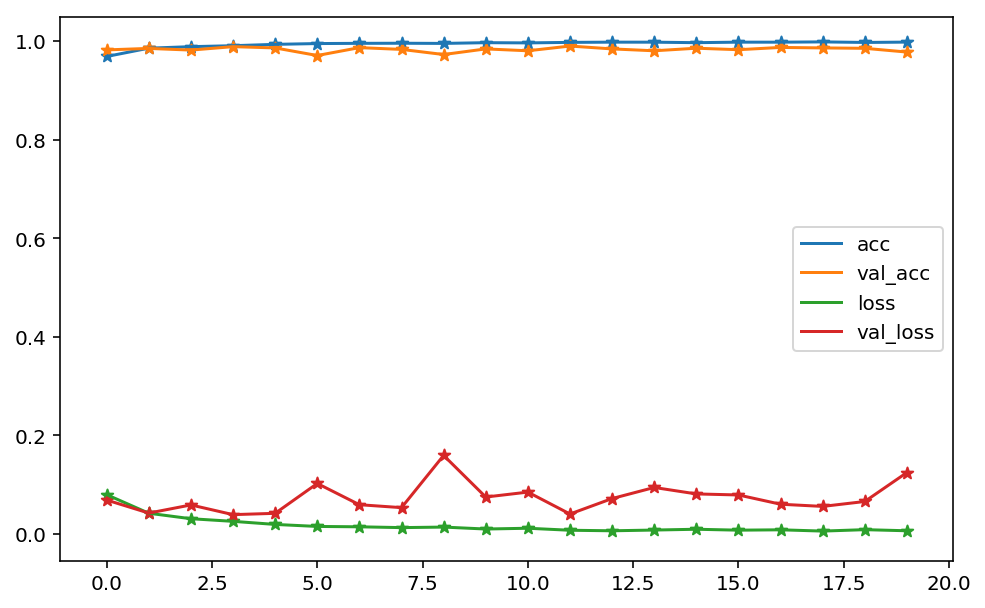

In [24]:
visualize_training(result.epoch, result.history)

In [26]:
save_training_log(result.history, 'log_xception.npz')

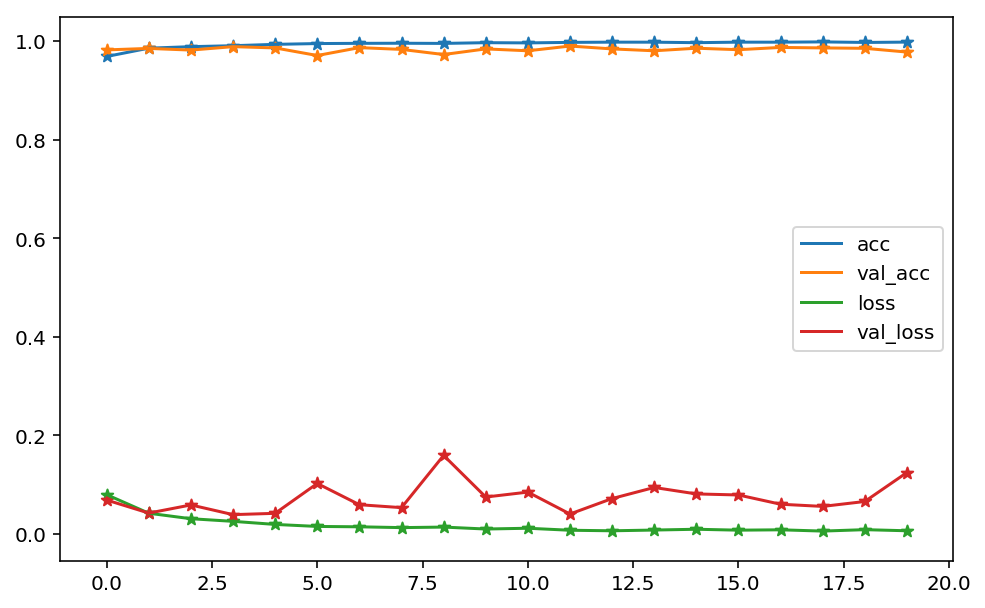

In [27]:
epoch, log = load_training_log('log_xception.npz')
visualize_training(epoch, log)

## 保存模型

In [96]:
WEIGHT = 'weight_xception'
MODEL_ = 'model_xception'

# save model
with open(MODEL_+'.json', 'w') as f:
    f.write(model.to_json())

# save weights
if not os.path.isfile(WEIGHT+'.h5'):
    model.save_weights(WEIGHT+'.h5', overwrite=True)

## 恢复模型

In [99]:
from keras.models import Model, model_from_json

# restore model
json_file = open(MODEL_+'.json', 'r')  
loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# restore weights
loaded_model.load_weights(WEIGHT+'.h5')

In [70]:
from keras.models import load_model

best_model = 'xception_04_0.0368.hdf5'

# restore both weights and model arch.
loaded_model = load_model(best_model)

## 预测

In [71]:
model = loaded_model

In [72]:
import pandas as pd

y_pred = model.predict_generator(test_gen, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_xception.csv', index=None)
df.head(10)

98/98 [==============================] - 150s 2s/step


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

----
# inception_resnet_v2

## 创建 ImageDataGenerator

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import inception_resnet_v2

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=inception_resnet_v2.preprocess_input,
    rescale=None,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    channel_shift_range=10,
    horizontal_flip=True,
    )

In [6]:
IMG_SIZE = 299
batch_size = 128

train_gen = img_generator.flow_from_directory(
    TRAIN_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_gen = img_generator.flow_from_directory(
    VAL_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
from keras.applications import inception_resnet_v2

test_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=inception_resnet_v2.preprocess_input,
    rescale=None,
    )

test_gen = test_generator.flow_from_directory(
    TEST_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

Found 12500 images belonging to 1 classes.


## 构建模型

In [8]:
from keras.applications import inception_resnet_v2
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Lambda

# preprocess_input
input_tensor = Input((IMG_SIZE, IMG_SIZE, 3))
x = input_tensor
#x = Lambda(inception_resnet_v2.preprocess_input)(input_tensor)

# base model from ResNet50
base_model = inception_resnet_v2.InceptionResNetV2(input_tensor=x, weights='imagenet', include_top=False)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# add a fully-connected layer
#x = Dense(1024, activation='relu')(x)

# and a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=input_tensor, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

219062272/219055592 [==============================] - 3s 0us/step


In [10]:
len(base_model.layers)

780

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

block8_7_ac (Activation)        (None, 8, 8, 2080)   0           block8_7[0][0]                   
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 8, 8, 192)    399360      block8_7_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 8, 8, 192)    576         conv2d_193[0][0]                 
__________________________________________________________________________________________________
activation_193 (Activation)     (None, 8, 8, 192)    0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 8, 8, 224)    129024      activation_193[0][0]             
__________________________________________________________________________________________________
batch_norm

## Fine Tune

In [18]:
for layer in base_model.layers[-80:]:
    layer.trainable = True

# this is the model we will train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 训练模型

In [21]:
epochs = 10
patience = 3

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

check_pt = ModelCheckpoint(
    'inception_res_v2_{epoch:02d}_{val_loss:.4f}.hdf5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    period=1
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.002,
    patience=patience, 
    verbose=1, 
    mode='auto'
)

In [23]:
result = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=[check_pt, early_stop],
    )

Epoch 1/10
157/157 [==============================] - 767s 5s/step - loss: 0.0531 - acc: 0.9788 - val_loss: 0.0485 - val_acc: 0.9842

Epoch 00001: saving model to inception_res_v2_01_0.0485.hdf5
Epoch 2/10
157/157 [==============================] - 687s 4s/step - loss: 0.0251 - acc: 0.9902 - val_loss: 0.0338 - val_acc: 0.9902

Epoch 00002: saving model to inception_res_v2_02_0.0338.hdf5
Epoch 3/10
157/157 [==============================] - 688s 4s/step - loss: 0.0197 - acc: 0.9922 - val_loss: 0.0147 - val_acc: 0.9952

Epoch 00003: saving model to inception_res_v2_03_0.0147.hdf5
Epoch 4/10
157/157 [==============================] - 689s 4s/step - loss: 0.0138 - acc: 0.9952 - val_loss: 0.0246 - val_acc: 0.9920

Epoch 00004: saving model to inception_res_v2_04_0.0246.hdf5
Epoch 5/10
157/157 [==============================] - 689s 4s/step - loss: 0.0116 - acc: 0.9959 - val_loss: 0.0156 - val_acc: 0.9944

Epoch 00005: saving model to inception_res_v2_05_0.0156.hdf5
Epoch 6/10
157/157 [=====

## 可视化训练结果

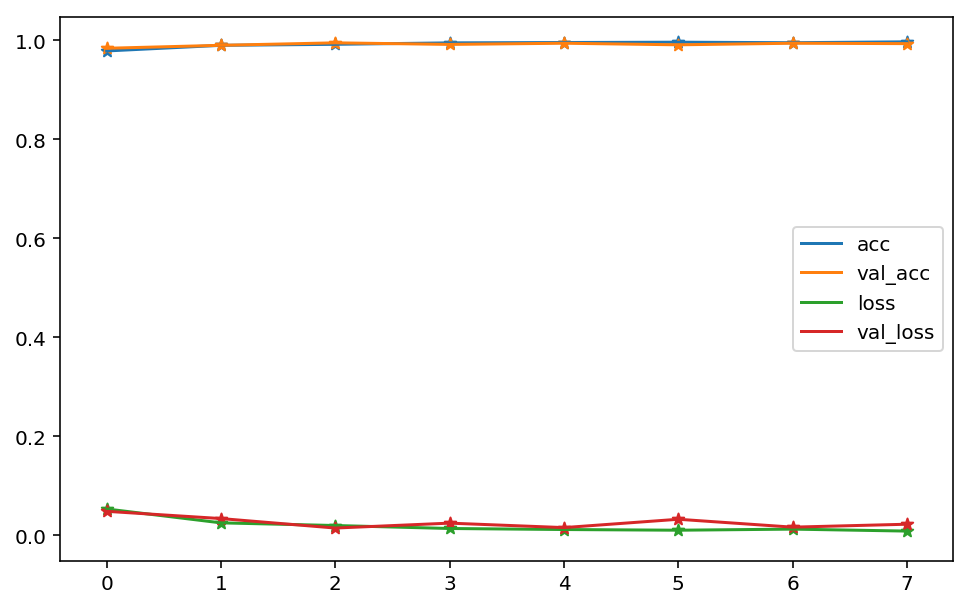

In [27]:
visualize_training(result.epoch, result.history)

In [28]:
save_training_log(result.history, 'log_inception_resnet_v2.npz')

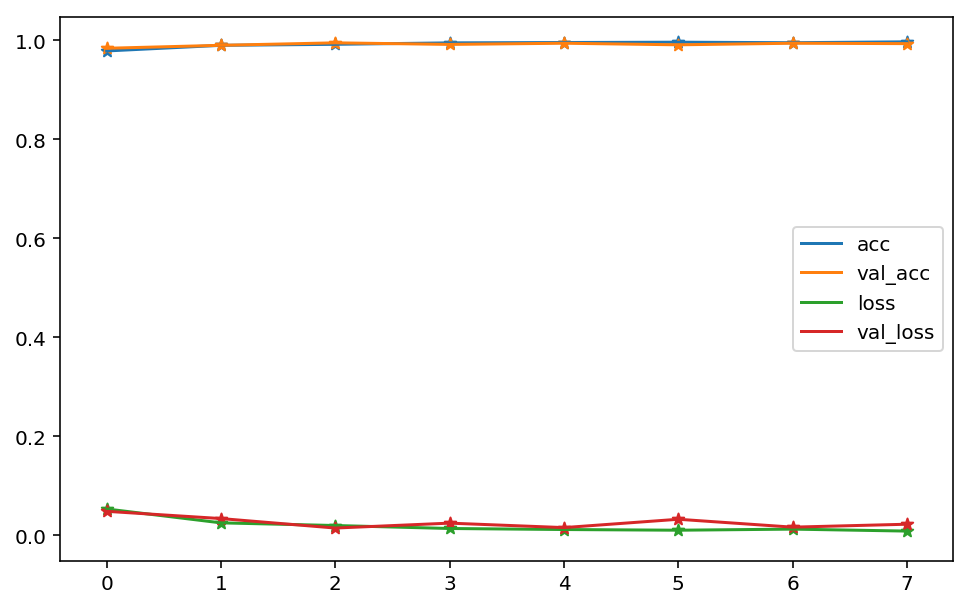

In [29]:
epoch, log = load_training_log('log_inception_resnet_v2.npz')
visualize_training(epoch, log)

## 保存模型

## 恢复模型

In [30]:
from keras.models import load_model

best_model = 'inception_res_v2_03_0.0147.hdf5'

# restore both weights and model arch.
loaded_model = load_model(best_model)

## 预测

In [31]:
model = loaded_model

In [32]:
import pandas as pd

y_pred = model.predict_generator(test_gen, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_inception_resnet_v2.csv', index=None)
df.head(10)

98/98 [==============================] - 340s 3s/step


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

----
# 特征提取

鉴于深度模型对于图片特征的提取能力，考虑使用上述模型分别提取特征，再将这些特征融合进一个分类器，再做分类

In [ ]:
from keras.applications import xception, inception_resnet_v2, resnet50

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

write_gap(ResNet50, (224, 224))
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)
